# Binary Classification (Cat&Dog)

Details/Source of data

    Details: Binary Classification (Cat&Dog)
    Transfer Learning & Un-freeze the top layers of model
    Model - MobilenetV2 (224,224)
    Seperate Train, validation and test dataset
    
    Source of data: https://www.kaggle.com/datasets/tongpython/cat-and-dog
    
@Khanthapak, 2022

### Import libraries 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2  import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

import numpy as np
from numpy import expand_dims
import pickle as p
import os
import cv2

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,auc

import datetime

### Configuration 

In [2]:
!nvidia-smi -L

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(f'Default GPU Device;{tf.test.gpu_device_name()}')

GPU 0: GeForce RTX 3050 Ti Laptop GPU (UUID: GPU-2650a9ac-ee16-37fa-8e5e-f22a6de8a4d1)
Num GPUs Available:  1
Default GPU Device;/device:GPU:0


In [3]:
tf.__version__

'2.8.0'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


Set batch size and image resize

In [5]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

Set path for train and validation directory

In [6]:
train_dir = "C:/Users/User/Pictures/cat-dog-train-valid-test/training_set"
validation_dir = "C:/Users/User/Pictures/cat-dog-train-valid-test/validation_set"
test_dir = "C:/Users/User/Pictures/cat-dog-train-valid-test/test_set"

In [7]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 6000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


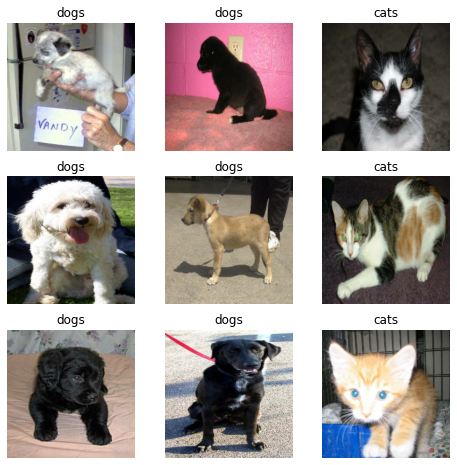

In [9]:
class_names = train_dataset.class_names

#print(len(class_names))

plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 125
Number of test batches: 125


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. 
To learn more about this method see the data performance guide.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

This process aims to reduce overfitting

In [12]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


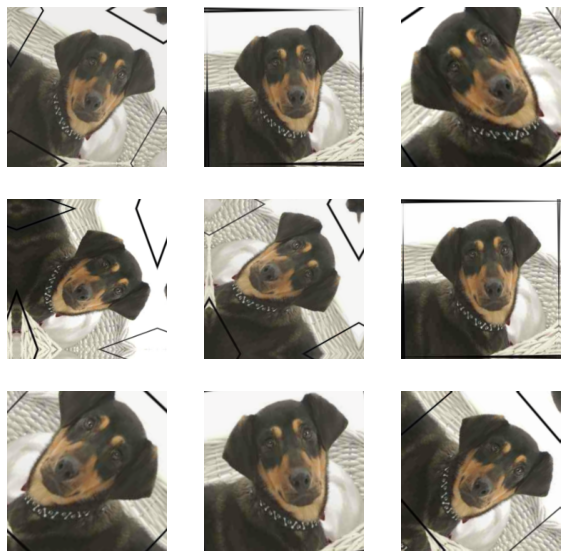

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Build model

In [15]:
preprocess_input = preprocess_input

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [20]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [21]:
prediction_layer = Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [22]:
inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

### Training model

Setting epoch, learning rate

In [23]:
base_learning_rate = 0.00001
initial_epochs = 20
fine_tune_epochs = 30

In [24]:
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
loss0, accuracy0 = model.evaluate(validation_dataset)

125/125 [==============================] - 5s 28ms/step - loss: 0.9306 - accuracy: 0.3375


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
375/375 [==============================] - 17s 41ms/step - loss: 0.8982 - accuracy: 0.4258 - val_loss: 0.7712 - val_accuracy: 0.4800
Epoch 2/20
375/375 [==============================] - 13s 35ms/step - loss: 0.7628 - accuracy: 0.5210 - val_loss: 0.6410 - val_accuracy: 0.6280
Epoch 3/20
375/375 [==============================] - 13s 35ms/step - loss: 0.6630 - accuracy: 0.6062 - val_loss: 0.5370 - val_accuracy: 0.7450
Epoch 4/20
375/375 [==============================] - 13s 35ms/step - loss: 0.5742 - accuracy: 0.6785 - val_loss: 0.4553 - val_accuracy: 0.8120
Epoch 5/20
375/375 [==============================] - 13s 35ms/step - loss: 0.5029 - accuracy: 0.7293 - val_loss: 0.3893 - val_accuracy: 0.8555
Epoch 6/20
375/375 [==============================] - 13s 35ms/step - loss: 0.4427 - accuracy: 0.7790 - val_loss: 0.3364 - val_accuracy: 0.8815
Epoch 7/20
375/375 [==============================] - 13s 35ms/step - loss: 0.3988 - accuracy: 0.8088 - val_loss: 0.2944 - val_accuracy:

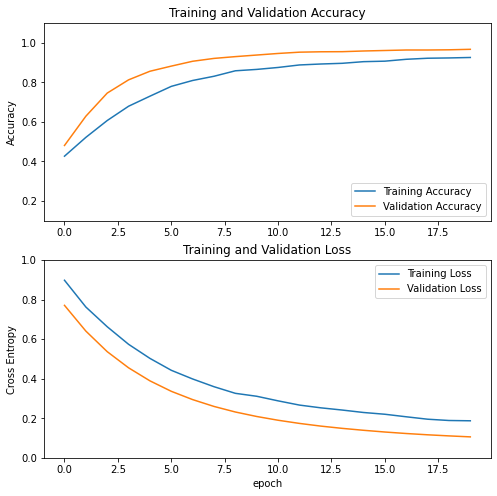

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.1,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the top layers of the model

Setting fine-tune epoch

In [29]:
fine_tune_epochs = 30

In [30]:
base_model.trainable = True

# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [31]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/50
375/375 [==============================] - 24s 57ms/step - loss: 0.1396 - accuracy: 0.9440 - val_loss: 0.0585 - val_accuracy: 0.9830
Epoch 21/50
375/375 [==============================] - 21s 56ms/step - loss: 0.1091 - accuracy: 0.9578 - val_loss: 0.0489 - val_accuracy: 0.9830
Epoch 22/50
375/375 [==============================] - 21s 56ms/step - loss: 0.0997 - accuracy: 0.9618 - val_loss: 0.0434 - val_accuracy: 0.9850
Epoch 23/50
375/375 [==============================] - 21s 56ms/step - loss: 0.0949 - accuracy: 0.9625 - val_loss: 0.0403 - val_accuracy: 0.9855
Epoch 24/50
375/375 [==============================] - 21s 56ms/step - loss: 0.0900 - accuracy: 0.9650 - val_loss: 0.0401 - val_accuracy: 0.9855
Epoch 25/50
375/375 [==============================] - 21s 56ms/step - loss: 0.0823 - accuracy: 0.9657 - val_loss: 0.0373 - val_accuracy: 0.9875
Epoch 26/50
375/375 [==============================] - 21s 56ms/step - loss: 0.0831 - accuracy: 0.9672 - val_loss: 0.0364 - val_ac

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

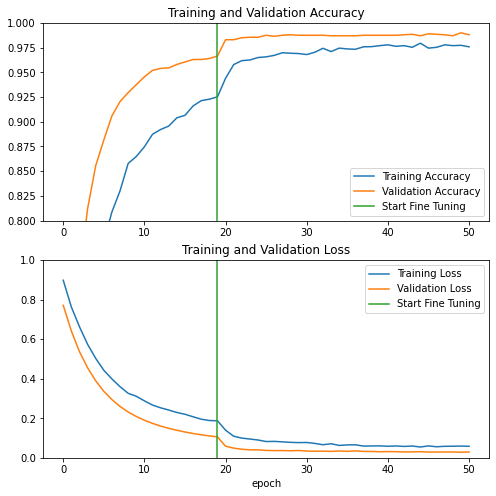

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

In [36]:
now = datetime.datetime.now()

year = now.strftime("%Y")
print("year:", year)

month = now.strftime("%m")
print("month:", month)

day = now.strftime("%d")
print("day:", day)

time = now.strftime("%H.%M.%S")
print("time:", time)

datetime = year + "_" + month + "_" + day + "_" + time
print(datetime)

year: 2022
month: 06
day: 20
time: 13.12.26
2022_06_20_13.12.26


In [37]:
datetime = year + "_" + month + "_" + day + "_" + time
filepath_history_model = "history_model_" + datetime

with open(filepath_history_model, 'wb') as file:
    p.dump(history.history, file)
    
filepath="model.h5_" + datetime
model.save(filepath)

filepath_model = "model.json5_" + datetime
filepath_weights = "weights_model.h5_" + datetime

model_json = model.to_json()
with open(filepath_model, "w") as json_file:
    json_file.write(model_json)
    model.save_weights(filepath_weights)

INFO:tensorflow:Assets written to: model.h5_2022_06_20_13.12.26\assets


### Load model

Setting loaded datetime

In [38]:
loaded_datetime = "2022_06_20_13.12.26"

In [39]:
filepath_loaded_model = "history_model_" + loaded_datetime
with open(filepath_loaded_model, 'rb') as file:
    his = p.load(file)
filepath="model.h5_"  + loaded_datetime
filepath_model = 'model.json5_'  + loaded_datetime
filepath_weights = 'weights_model.h5_'  + loaded_datetime


with open(filepath_model, 'r') as f:
    loaded_model_json = f.read()
    #print(loaded_model_json)
    saved_model = model_from_json(loaded_model_json)
    saved_model.load_weights(filepath_weights)    
    print("Loaded model from disk")
    
    saved_model.summary()

Loaded model from disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                      

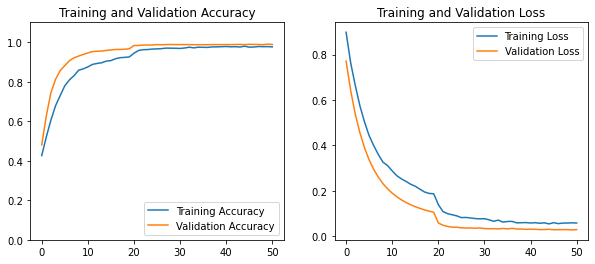

In [40]:
acc = his['accuracy']
val_acc = his['val_accuracy']

loss=his['loss']
val_loss=his['val_loss']

#print(acc,val_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.0,1.1))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluation 

In [41]:
saved_model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

loss2, accuracy2 = saved_model.evaluate(test_dataset)
print('Test accuracy :', accuracy2)

125/125 [==============================] - 4s 27ms/step - loss: 0.0314 - accuracy: 0.9900
Test accuracy : 0.9900000095367432


Classification report and Confusion matrix

In [42]:
labels = []
predicts = []
for image,label in test_dataset.take(-1):
    labels.extend(label)
    predicts.extend(saved_model.predict(image))

labels = np.array(labels)
predicts = np.array(predicts)

#print(labels.shape)
#print(predicts.shape)

predictions = tf.nn.sigmoid(predicts)
#print('Predictions:\n', predictions)

#print(predictions.shape)

predictions_results = tf.where(predictions < 0.5, 0, 1)

#print('Predictions_results:\n', predictions_results)

print(classification_report(labels,predictions_results, target_names=class_names, digits=4))
print(confusion_matrix(labels,predictions_results))

              precision    recall  f1-score   support

        cats     0.9919    0.9840    0.9880      1000
        dogs     0.9841    0.9920    0.9880      1000

    accuracy                         0.9880      2000
   macro avg     0.9880    0.9880    0.9880      2000
weighted avg     0.9880    0.9880    0.9880      2000

[[984  16]
 [  8 992]]


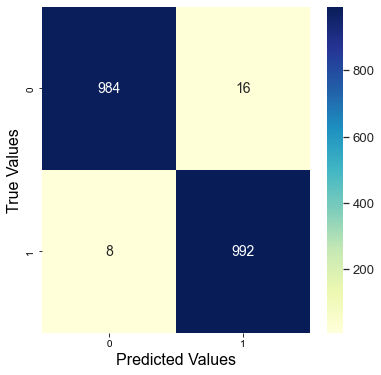

In [43]:
cm = confusion_matrix(labels, predictions_results)
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
     cbar = True, cmap="YlGnBu", fmt="d");
ax1.set_ylabel('True Values',fontsize=16)
ax1.set_xlabel('Predicted Values',fontsize=16)
plt.show()

ROC & AUC

In [44]:
def plot_ROC(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

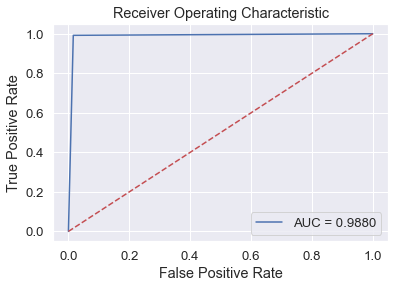

In [45]:
# Plot ROC
plot_ROC(labels, predictions_results)

In [46]:
fpr, tpr, threshold = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

In [47]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff

roc_df = pd.DataFrame(data={'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': threshold})
roc_df.head()

False Positive Rate  True Positive Rate  Threshold
0                  0.0               0.000   1.999998
1                  0.0               0.001   0.999998
2                  0.0               0.010   0.999994
3                  0.0               0.012   0.999994
4                  0.0               0.017   0.999993

In [48]:
def binary_roc_plot(roc_df, roc_auc):
    fig = px.area(
        data_frame=roc_df, 
        x='False Positive Rate', 
        y='True Positive Rate',
        hover_data=['Threshold'], 
        title=f'ROC Curve (AUC={roc_auc:.4f})',
        width=700, height=500,
    )

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    hovertemplate = 'False Positive Rate=%{x:.4f}<br>True Positive Rate=%{y:.4f}<br>Threshold=%{customdata[0]:.4f}'
    fig.update_traces(hovertemplate=hovertemplate)

    fig.show()

In [49]:
binary_roc_plot(roc_df, roc_auc)

In [50]:
predictions_results_update = tf.where(predictions < 0.6047, 0, 1)
#0.5282
print(classification_report(labels,predictions_results_update, target_names=class_names, digits=4))
print(confusion_matrix(labels,predictions_results_update))

              precision    recall  f1-score   support

        cats     0.9910    0.9900    0.9905      1000
        dogs     0.9900    0.9910    0.9905      1000

    accuracy                         0.9905      2000
   macro avg     0.9905    0.9905    0.9905      2000
weighted avg     0.9905    0.9905    0.9905      2000

[[990  10]
 [  9 991]]


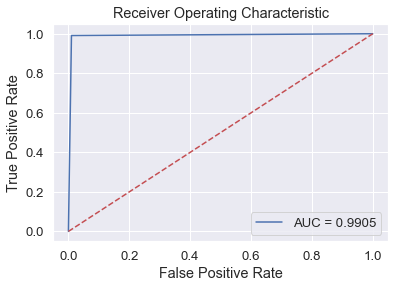

In [51]:
plot_ROC(labels, predictions_results_update)